In [1]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz 
from graphviz import Digraph
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier

from pdpbox import pdp, get_dataset, info_plots
import shap
from xgboost import XGBClassifier 

import h2o
from h2o.estimators import *
from h2o.grid import *

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
analysis_df = pd.read_csv("./ross_model_data.csv", low_memory=False)

In [4]:
analysis_df.shape
analysis_df.dtypes

(443578, 168)

TXN_UID                int64
CHECK_NUMBER         float64
FACE_AMOUNT          float64
PRODUCT_CODE           int64
POSITIVE_ID_GRADE     object
                      ...   
LAST_CHK_UNAPP        object
wZIP3                  int64
CHALL_IND_MOD         object
wCHECK_NUMBER          int64
LOSS_IND               int64
Length: 168, dtype: object

In [5]:
#create binary net loss indicator
analysis_df['NET_LOSS_BINARY'] = np.where(analysis_df['LOSS_IND']==1,1,0)
analysis_df.groupby('LOSS_IND').agg({'TXN_UID':'count','NET_LOSS_BINARY':['sum','mean']})

TXN_UID NET_LOSS_BINARY     
           count             sum mean
LOSS_IND                             
-1        441107               0    0
 1          2471            2471    1

In [6]:
#summarize data
approve_stats = analysis_df[analysis_df['NAT_AUTH_RESULT']=='A'].groupby(['SEGMENT','CHALL_IND_MOD']).agg({'TXN_UID':'count','NET_LOSS_BINARY':['sum','mean']})
decline_counts = analysis_df[analysis_df['NAT_AUTH_RESULT']=='D'].groupby(['SEGMENT','CHALL_IND_MOD']).agg({'TXN_UID':'count'})
decline_counts.rename(columns = {'TXN_UID':'DECLINE_COUNT'}, inplace=True)

agg_stats = pd.concat([approve_stats,decline_counts], axis=1)

agg_stats['DECLINE_RATE'] = agg_stats['DECLINE_COUNT']/(agg_stats['DECLINE_COUNT'] + agg_stats[('TXN_UID', 'count')])
agg_stats

(TXN_UID, count)  (NET_LOSS_BINARY, sum)  \
SEGMENT CHALL_IND_MOD                                             
C19     N                          5217                     340   
        Y                         86398                     188   
MID     N                          9450                     396   
        Y                        132167                     295   
YPR     N                         15053                     798   
        Y                        179676                     422   

                       (NET_LOSS_BINARY, mean)  DECLINE_COUNT  DECLINE_RATE  
SEGMENT CHALL_IND_MOD                                                        
C19     N                             0.065172           3893      0.427333  
        Y                             0.002176           1531      0.017412  
MID     N                             0.041905           4194      0.307388  
        Y                             0.002232           1492      0.011163  
YPR     N                             0.053013           3566      0.191525  
        Y                             0.002349            941      0.005210

In [7]:
analysis_df[analysis_df['SEGMENT'] != 'C19'].agg({'NET_LOSS_BINARY':'sum'})

NET_LOSS_BINARY    1936
dtype: int64

In [8]:
#pull out approved volume to fit and validate the models on, also limit this down to challenger for these models
approve_vol = analysis_df[analysis_df['NAT_AUTH_RESULT'] == 'A']
approve_vol.drop(columns = ['NAT_AUTH_RESULT','LOSS_IND'], inplace = True)
approve_vol.groupby(['CHALL_IND_MOD','NET_LOSS_BINARY']).agg({'TXN_UID':'count'})

TXN_UID
CHALL_IND_MOD NET_LOSS_BINARY         
N             0                  28186
              1                   1534
Y             0                 397336
              1                    905

In [9]:
#pull out target var
y_train = approve_vol[approve_vol['SEGMENT'] == 'C19'].NET_LOSS_BINARY
y_val = approve_vol[approve_vol['SEGMENT'] == 'YPR'].NET_LOSS_BINARY
y_test = approve_vol[approve_vol['SEGMENT'] == 'MID'].NET_LOSS_BINARY
y_deep_dive = analysis_df.NET_LOSS_BINARY


#columns to drop
drop_cols = ['TXN_UID','SEGMENT','NET_LOSS_BINARY','SIC','CHAIN','id_count','MICR_COUNT','DL_COUNT','ZIP2',
            'CHECK_NUMBER','ZIP3','PRODUCT_CODE',
            'MEAN_APPR_CHECK_NO_30D_L1','MEAN_APPR_CHECK_NO_6M_L14',
            'AVG_APPR_24M_L1','AVG_APPR_24M_L7','AVG_APPR_6M_L1','AVG_APPR_6M_L14','AVG_APPR_CHN_6M_L14',
            'AVG_T6M_DLR_L1','AVG_T1D_DLR_RT','AVG_T24M_DLR_L1','AVG_APPR_CHN_21D_L1',
            'AVG_UNPAID_CLM','CLAIM_D_6M_L','CLAIM_C_3M_L',
            'MIN_APPR_CHN_24M_L7','MIN_APPR_ZIP_12M_L7']

X_train = approve_vol[approve_vol['SEGMENT'] == 'C19'].drop(columns = drop_cols)
X_val = approve_vol[approve_vol['SEGMENT'] == 'YPR'].drop(columns = drop_cols)
X_test = approve_vol[approve_vol['SEGMENT'] == 'MID'].drop(columns = drop_cols)

#I also need a data frame of all transactions, including declines, that I can score for deeper analysis
X_deep_dive = analysis_df.drop(columns = drop_cols)
X_deep_dive.drop(columns = ['NAT_AUTH_RESULT','LOSS_IND'], inplace=True)

X_train.shape
X_val.shape
X_test.shape

y_train.shape
y_val.shape
y_test.shape

X_deep_dive.shape
y_deep_dive.shape

(91615, 139)

(194729, 139)

(141617, 139)

(91615,)

(194729,)

(141617,)

(443578, 139)

(443578,)

In [35]:
X_train.head()
y_train.head()

,FACE_AMOUNT,POSITIVE_ID_GRADE,CHECK_TYPE,OUTREG,STATION_STATE,ECC_IND,LOCAL_HOUR,NO_ID,NID_NO,FM_SCAN_CODE,...,CHK_DEV_MEAN_30D_L1,FA_DEV_CHN_MEAN_6M_L14,CHK_DEV_MEAN_6M_L14,R_D30D_D6M_APPR_V1,R_FA_UNPAID_CLM,LAST_CHK_APP,LAST_CHK_UNAPP,wZIP3,CHALL_IND_MOD,wCHECK_NUMBER
62,52.53,V,P,N,NJ,N,11,NaN,NaN,S,...,NaN,-0.433125,-0.016926,0.000000,NaN,Y,N,-555,Y,1
63,49.25,NaN,P,N,NJ,N,13,NaN,NaN,S,...,NaN,NaN,NaN,NaN,NaN,Y,N,-555,Y,2
64,83.15,W,P,N,NJ,N,14,NaN,NaN,S,...,NaN,NaN,NaN,NaN,NaN,Y,N,-555,Y,2
65,26.98,Z,P,N,NJ,N,17,NaN,NaN,S,...,4.486911,-0.810494,0.716782,1.889103,NaN,Y,N,-555,Y,2
66,57.71,A,P,N,NJ,N,15,NaN,NaN,S,...,NaN,NaN,0.003820,0.000000,NaN,Y,N,-555,Y,1


62    0
63    0
64    0
65    0
66    0
Name: NET_LOSS_BINARY, dtype: int32

In [10]:
#need to replace missing values, different logic for numeric vs categoricals
# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype in ['int64', 'float64']]
numerical_cols

['FACE_AMOUNT',
 'LOCAL_HOUR',
 'NO_ID',
 'NID_NO',
 'NYCE_RESP_CODE',
 'DAY',
 'AGE',
 'APPR_C_3M_RT',
 'ALL_C_21D_RT',
 'ALL_D_21D_RT',
 'MIN_DECL_21D_RT',
 'SIC_APPR_D_21D_RT',
 'APPR_C_14D_RT',
 'ALL_D_9D_RT',
 'SIC_APPR_D_9D_RT',
 'NON_SIM_3DAY_C',
 'NON_SIM_6DAY_D',
 'APPR_C_7D_RT',
 'OUT_OF_STATE_7D',
 'ALL_D_6D_RT',
 'STR_ALL_C_6D_RT',
 'ALL_C_3D_RT',
 'ALL_C_1D_RT',
 'ALL_180MIN_D',
 'SAME_STA_180MIN_D',
 'SAME_CHN_60MIN_D',
 'SICCOUNT',
 'MINS_BET_ILF_OLDVEL',
 'LARGEST_APPROVAL_SIC',
 'SMALLEST_DECLINE_SIC',
 'CHK_NUM_FWD_DAYS_0',
 'CHK_NUM_FWD_DAYS_2',
 'CHK_NUM_FWD_DAYS_4',
 'CHK_NUM_INCR',
 'AVG_CHKNUM_RATE',
 'STD_DEV_CHKNUM_RATE',
 'AVG_DIFF',
 'STD_NORM_DIFF',
 'ALL_C_24M_L1',
 'T24M_DOL_AMT',
 'MAX_T24M_DLR',
 'APPR_C_24M_L1',
 'APPR_D_24M_L1',
 'MAX_APPR_24M_L1',
 'MIN_DECL_24M_L1',
 'MAX_SIC_24M_L1',
 'ALL_C_12M_L1',
 'APPR_C_12M_L1',
 'APPR_D_12M_L1',
 'ZIP3_APPR_C_12M_L1',
 'ALL_C_6M_L1',
 'APPR_D_6M_L1',
 'ALL_C_3M_L1',
 'MAX_APPR_3M_L1',
 'DECL_D_3M_L1',
 'APPR_

In [11]:
#convert categoricals to strings 
convert_to_cat = ['NYCE_RESP_CODE','DAY','CAT_SIC_MAX_DLR_AMT_24M','LARGEST_APPROVAL_SIC',
                  'SMALLEST_DECLINE_SIC','wCHECK_NUMBER','wZIP3']

for i in convert_to_cat:
    X_train[i] = X_train[i].astype('str',copy=False)
    X_val[i] = X_val[i].astype('str',copy=False)
    X_deep_dive[i] = X_deep_dive[i].astype('str',copy=False)

In [12]:
numerical_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype in ['int64', 'float64']]
numerical_cols

['FACE_AMOUNT',
 'LOCAL_HOUR',
 'NO_ID',
 'NID_NO',
 'AGE',
 'APPR_C_3M_RT',
 'ALL_C_21D_RT',
 'ALL_D_21D_RT',
 'MIN_DECL_21D_RT',
 'SIC_APPR_D_21D_RT',
 'APPR_C_14D_RT',
 'ALL_D_9D_RT',
 'SIC_APPR_D_9D_RT',
 'NON_SIM_3DAY_C',
 'NON_SIM_6DAY_D',
 'APPR_C_7D_RT',
 'OUT_OF_STATE_7D',
 'ALL_D_6D_RT',
 'STR_ALL_C_6D_RT',
 'ALL_C_3D_RT',
 'ALL_C_1D_RT',
 'ALL_180MIN_D',
 'SAME_STA_180MIN_D',
 'SAME_CHN_60MIN_D',
 'SICCOUNT',
 'MINS_BET_ILF_OLDVEL',
 'CHK_NUM_FWD_DAYS_0',
 'CHK_NUM_FWD_DAYS_2',
 'CHK_NUM_FWD_DAYS_4',
 'CHK_NUM_INCR',
 'AVG_CHKNUM_RATE',
 'STD_DEV_CHKNUM_RATE',
 'AVG_DIFF',
 'STD_NORM_DIFF',
 'ALL_C_24M_L1',
 'T24M_DOL_AMT',
 'MAX_T24M_DLR',
 'APPR_C_24M_L1',
 'APPR_D_24M_L1',
 'MAX_APPR_24M_L1',
 'MIN_DECL_24M_L1',
 'MAX_SIC_24M_L1',
 'ALL_C_12M_L1',
 'APPR_C_12M_L1',
 'APPR_D_12M_L1',
 'ZIP3_APPR_C_12M_L1',
 'ALL_C_6M_L1',
 'APPR_D_6M_L1',
 'ALL_C_3M_L1',
 'MAX_APPR_3M_L1',
 'DECL_D_3M_L1',
 'APPR_D_30D_L1',
 'DECL_C_30D_L1',
 'ALL_C_21D_L1',
 'APPR_C_14D_L1',
 'ALL_D_9D_L1

In [37]:
# Impute numeric columns, simple fill with -999 value
my_numeric_imputer = SimpleImputer(strategy='constant', fill_value=-999)
num_X_train = X_train[numerical_cols]
num_X_val = X_val[numerical_cols]
num_X_test = X_test[numerical_cols]

num_X_deep_dive = X_deep_dive[numerical_cols]

imputed_num_X_train = pd.DataFrame(my_numeric_imputer.fit_transform(num_X_train))
imputed_num_X_val = pd.DataFrame(my_numeric_imputer.transform(num_X_val))
imputed_num_X_test = pd.DataFrame(my_numeric_imputer.transform(num_X_test))

imputed_num_X_deep_dive = pd.DataFrame(my_numeric_imputer.transform(num_X_deep_dive))

# Imputation removed column names; put them back
imputed_num_X_train.columns = num_X_train.columns
imputed_num_X_val.columns = num_X_val.columns
imputed_num_X_test.columns = num_X_test.columns

imputed_num_X_deep_dive.columns = num_X_deep_dive.columns

#need to return index back to the data frames
imputed_num_X_train.index = X_train.index
imputed_num_X_val.index = X_val.index
imputed_num_X_test.index = X_test.index
imputed_num_X_deep_dive.index = X_deep_dive.index

imputed_num_X_train.head()

,FACE_AMOUNT,LOCAL_HOUR,NO_ID,NID_NO,AGE,APPR_C_3M_RT,ALL_C_21D_RT,ALL_D_21D_RT,MIN_DECL_21D_RT,SIC_APPR_D_21D_RT,...,R_T6M_T24M_C,R_T12M_T24M_C,R_D30D_D24M_APPR,R_FA_MAX24M,R_FA_MAX3M,CHK_DEV_MEAN_30D_L1,FA_DEV_CHN_MEAN_6M_L14,CHK_DEV_MEAN_6M_L14,R_D30D_D6M_APPR_V1,R_FA_UNPAID_CLM
62,52.53,11.0,-999.0,-999.0,91.0,0.0,0.0,-999.00,-999.0,-999.0,...,0.576499,1.023935,0.000000,0.211388,-999.000000,-999.000000,-0.433125,-0.016926,0.000000,-999.0
63,49.25,13.0,-999.0,-999.0,83.0,0.0,0.0,-999.00,-999.0,-999.0,...,-999.000000,-999.000000,0.000000,1.388497,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0
64,83.15,14.0,-999.0,-999.0,68.0,0.0,0.0,-999.00,-999.0,-999.0,...,-999.000000,0.890806,0.000000,0.598460,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0
65,26.98,17.0,-999.0,-999.0,52.0,5.0,1.0,79.23,-999.0,0.0,...,1.204239,1.170412,2.260201,0.108646,0.248939,4.486911,-0.810494,0.716782,1.889103,-999.0
66,57.71,15.0,-999.0,-999.0,45.0,0.0,0.0,-999.00,-999.0,-999.0,...,0.560369,0.697692,0.000000,0.370363,-999.000000,-999.000000,-999.000000,0.003820,0.000000,-999.0


In [14]:
#inspect categorical columns prior imputation
categorical_cols = [cname for cname in X_train.columns if
                    X_train[cname].nunique() < 30 and 
                    X_train[cname].dtype == "object"]
categorical_cols

['POSITIVE_ID_GRADE',
 'CHECK_TYPE',
 'OUTREG',
 'ECC_IND',
 'FM_SCAN_CODE',
 'NYCE_AVAIL_FUNDS',
 'NYCE_RESP_CODE',
 'ID_STATION_STATE',
 'DAY',
 'CAT_SIC_MAX_DLR_AMT_24M',
 'T24M_ZIP_MAX_IND',
 'T24M_ZIP_MAX_NO_CHK_IND',
 'LAST_CHK_APP',
 'LAST_CHK_UNAPP',
 'wZIP3',
 'CHALL_IND_MOD',
 'wCHECK_NUMBER']

In [38]:
#Impute character values
my_categorical_imputer = SimpleImputer(strategy='constant', fill_value='Z')
char_X_train = X_train[categorical_cols]
char_X_val = X_val[categorical_cols]
char_X_test = X_test[categorical_cols]

char_X_deep_dive = X_deep_dive[categorical_cols]

imputed_char_X_train = pd.DataFrame(my_categorical_imputer.fit_transform(char_X_train))
imputed_char_X_val = pd.DataFrame(my_categorical_imputer.transform(char_X_val))
imputed_char_X_test = pd.DataFrame(my_categorical_imputer.transform(char_X_test))

imputed_char_X_deep_dive = pd.DataFrame(my_categorical_imputer.transform(char_X_deep_dive))

# Imputation removed column names; put them back
imputed_char_X_train.columns = char_X_train.columns
imputed_char_X_val.columns = char_X_val.columns
imputed_char_X_test.columns = char_X_test.columns
imputed_char_X_deep_dive.columns = char_X_deep_dive.columns

#need to return index back to the data frames
imputed_char_X_train.index = X_train.index
imputed_char_X_val.index = X_val.index
imputed_char_X_test.index = X_test.index
imputed_char_X_deep_dive.index = X_deep_dive.index

imputed_char_X_train.head(10)

,POSITIVE_ID_GRADE,CHECK_TYPE,OUTREG,ECC_IND,FM_SCAN_CODE,NYCE_AVAIL_FUNDS,NYCE_RESP_CODE,ID_STATION_STATE,DAY,CAT_SIC_MAX_DLR_AMT_24M,T24M_ZIP_MAX_IND,T24M_ZIP_MAX_NO_CHK_IND,LAST_CHK_APP,LAST_CHK_UNAPP,wZIP3,CHALL_IND_MOD,wCHECK_NUMBER
62,V,P,N,N,S,Z,nan,MATCH,3,13.0,Y,Y,Y,N,-555,Y,1
63,Z,P,N,N,S,Z,nan,MATCH,5,9.0,N,N,Y,N,-555,Y,2
64,W,P,N,N,S,Z,nan,MATCH,5,9.0,Y,Y,Y,N,-555,Y,2
65,Z,P,N,N,S,Z,nan,MATCH,5,16.0,N,Y,Y,N,-555,Y,2
66,A,P,N,N,S,Z,nan,MATCH,6,6.0,Y,Y,Y,N,-555,Y,1
67,V,P,N,N,S,Z,nan,MATCH,2,13.0,Y,Y,Y,N,-555,Y,1
68,V,P,N,N,S,Z,nan,MATCH,3,13.0,N,Y,Y,N,-555,Y,2
69,V,P,N,N,S,Z,nan,MATCH,4,13.0,N,Y,Y,N,-555,Y,1
70,B,P,N,N,S,Z,nan,MATCH,4,16.0,Y,N,Y,N,-555,Y,2
71,C,P,N,N,S,Z,nan,MATCH,4,8.0,N,N,Y,N,-555,Y,2


In [39]:
#I need to purge the columns that take on only one value
single_val_cat_cols = [cname for cname in imputed_char_X_train.columns if
                    imputed_char_X_train[cname].nunique() < 2]
single_val_cat_cols

['ECC_IND']

In [40]:
imputed_char_X_train.drop(columns = single_val_cat_cols,inplace=True)
imputed_char_X_val.drop(columns = single_val_cat_cols,inplace=True)
imputed_char_X_test.drop(columns = single_val_cat_cols,inplace=True)

imputed_char_X_deep_dive.drop(columns = single_val_cat_cols,inplace=True)

imputed_char_X_train.head()

,POSITIVE_ID_GRADE,CHECK_TYPE,OUTREG,FM_SCAN_CODE,NYCE_AVAIL_FUNDS,NYCE_RESP_CODE,ID_STATION_STATE,DAY,CAT_SIC_MAX_DLR_AMT_24M,T24M_ZIP_MAX_IND,T24M_ZIP_MAX_NO_CHK_IND,LAST_CHK_APP,LAST_CHK_UNAPP,wZIP3,CHALL_IND_MOD,wCHECK_NUMBER
62,V,P,N,S,Z,nan,MATCH,3,13.0,Y,Y,Y,N,-555,Y,1
63,Z,P,N,S,Z,nan,MATCH,5,9.0,N,N,Y,N,-555,Y,2
64,W,P,N,S,Z,nan,MATCH,5,9.0,Y,Y,Y,N,-555,Y,2
65,Z,P,N,S,Z,nan,MATCH,5,16.0,N,Y,Y,N,-555,Y,2
66,A,P,N,S,Z,nan,MATCH,6,6.0,Y,Y,Y,N,-555,Y,1


In [41]:
#now I need to convert the categorical columms to binary indicators with one-hot encoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_imputed_char_X_train = pd.DataFrame(OH_encoder.fit_transform(imputed_char_X_train))
OH_cols_imputed_char_X_val = pd.DataFrame(OH_encoder.transform(imputed_char_X_val))
OH_cols_imputed_char_X_test = pd.DataFrame(OH_encoder.transform(imputed_char_X_test))

OH_cols_imputed_char_X_deep_dive = pd.DataFrame(OH_encoder.transform(imputed_char_X_deep_dive))

# One-hot encoding removed index; put it back
OH_cols_imputed_char_X_train.index = X_train.index
OH_cols_imputed_char_X_val.index = X_val.index
OH_cols_imputed_char_X_test.index = X_test.index

OH_cols_imputed_char_X_deep_dive.index = X_deep_dive.index

#and need to bring in the column names 
OH_cols_imputed_char_X_train.columns = OH_encoder.get_feature_names(list(imputed_char_X_train.columns))
OH_cols_imputed_char_X_val.columns = OH_encoder.get_feature_names(list(imputed_char_X_val.columns))
OH_cols_imputed_char_X_test.columns = OH_encoder.get_feature_names(list(imputed_char_X_test.columns))

OH_cols_imputed_char_X_deep_dive.columns = OH_encoder.get_feature_names(list(imputed_char_X_deep_dive.columns))

OH_cols_imputed_char_X_train

,POSITIVE_ID_GRADE_A,POSITIVE_ID_GRADE_B,POSITIVE_ID_GRADE_C,POSITIVE_ID_GRADE_D,POSITIVE_ID_GRADE_E,POSITIVE_ID_GRADE_F,POSITIVE_ID_GRADE_V,POSITIVE_ID_GRADE_W,POSITIVE_ID_GRADE_X,POSITIVE_ID_GRADE_Y,...,LAST_CHK_UNAPP_N,LAST_CHK_UNAPP_Y,wZIP3_-555,wZIP3_1,wZIP3_666,CHALL_IND_MOD_N,CHALL_IND_MOD_Y,wCHECK_NUMBER_1,wCHECK_NUMBER_2,wCHECK_NUMBER_3
62,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
66,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
443534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
443535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
443536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [43]:
#now merge the categorical and numeric columns back together
imputed_X_train = pd.concat([imputed_num_X_train, OH_cols_imputed_char_X_train], axis=1)
imputed_X_val = pd.concat([imputed_num_X_val, OH_cols_imputed_char_X_val], axis=1)
imputed_X_test = pd.concat([imputed_num_X_test, OH_cols_imputed_char_X_test], axis=1)

imputed_X_deep_dive = pd.concat([imputed_num_X_deep_dive, OH_cols_imputed_char_X_deep_dive], axis=1)

imputed_X_train.head()

,FACE_AMOUNT,LOCAL_HOUR,NO_ID,NID_NO,AGE,APPR_C_3M_RT,ALL_C_21D_RT,ALL_D_21D_RT,MIN_DECL_21D_RT,SIC_APPR_D_21D_RT,...,LAST_CHK_UNAPP_N,LAST_CHK_UNAPP_Y,wZIP3_-555,wZIP3_1,wZIP3_666,CHALL_IND_MOD_N,CHALL_IND_MOD_Y,wCHECK_NUMBER_1,wCHECK_NUMBER_2,wCHECK_NUMBER_3
62,52.53,11.0,-999.0,-999.0,91.0,0.0,0.0,-999.00,-999.0,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
63,49.25,13.0,-999.0,-999.0,83.0,0.0,0.0,-999.00,-999.0,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
64,83.15,14.0,-999.0,-999.0,68.0,0.0,0.0,-999.00,-999.0,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
65,26.98,17.0,-999.0,-999.0,52.0,5.0,1.0,79.23,-999.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
66,57.71,15.0,-999.0,-999.0,45.0,0.0,0.0,-999.00,-999.0,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [44]:
#bring the the responses back to the feature data sets
train = pd.concat([y_train, imputed_X_train], axis=1)
valid = pd.concat([y_val, imputed_X_val], axis=1)
test = pd.concat([y_test, imputed_X_test], axis=1)

deep_dive = pd.concat([y_deep_dive, imputed_X_deep_dive], axis=1)

valid.columns

Index(['NET_LOSS_BINARY', 'FACE_AMOUNT', 'LOCAL_HOUR', 'NO_ID', 'NID_NO',
       'AGE', 'APPR_C_3M_RT', 'ALL_C_21D_RT', 'ALL_D_21D_RT',
       'MIN_DECL_21D_RT',
       ...
       'LAST_CHK_UNAPP_N', 'LAST_CHK_UNAPP_Y', 'wZIP3_-555', 'wZIP3_1',
       'wZIP3_666', 'CHALL_IND_MOD_N', 'CHALL_IND_MOD_Y', 'wCHECK_NUMBER_1',
       'wCHECK_NUMBER_2', 'wCHECK_NUMBER_3'],
      dtype='object', length=188)

In [45]:
train.head()

,NET_LOSS_BINARY,FACE_AMOUNT,LOCAL_HOUR,NO_ID,NID_NO,AGE,APPR_C_3M_RT,ALL_C_21D_RT,ALL_D_21D_RT,MIN_DECL_21D_RT,...,LAST_CHK_UNAPP_N,LAST_CHK_UNAPP_Y,wZIP3_-555,wZIP3_1,wZIP3_666,CHALL_IND_MOD_N,CHALL_IND_MOD_Y,wCHECK_NUMBER_1,wCHECK_NUMBER_2,wCHECK_NUMBER_3
62,0,52.53,11.0,-999.0,-999.0,91.0,0.0,0.0,-999.00,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
63,0,49.25,13.0,-999.0,-999.0,83.0,0.0,0.0,-999.00,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
64,0,83.15,14.0,-999.0,-999.0,68.0,0.0,0.0,-999.00,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
65,0,26.98,17.0,-999.0,-999.0,52.0,5.0,1.0,79.23,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
66,0,57.71,15.0,-999.0,-999.0,45.0,0.0,0.0,-999.00,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [21]:
h2o.init(url='http://localhost:8889')

Checking whether there is an H2O instance running at http://localhost:8889 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.281-b09, mixed mode)
  Starting server from C:\Users\jason.hosler\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\JASON~1.HOS\AppData\Local\Temp\tmp6r50uyfv
  JVM stdout: C:\Users\JASON~1.HOS\AppData\Local\Temp\tmp6r50uyfv\h2o_jason_hosler_started_from_python.out
  JVM stderr: C:\Users\JASON~1.HOS\AppData\Local\Temp\tmp6r50uyfv\h2o_jason_hosler_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,1 month and 8 days
H2O_cluster_name:,H2O_from_python_jason_hosler_b261bd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,14.21 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"accepting new members, healthy"


In [46]:
#convert my dataframe to h2o frames
train_h = h2o.H2OFrame(train)
valid_h = h2o.H2OFrame(valid)
test_h = h2o.H2OFrame(test)
deep_dive_h = h2o.H2OFrame(deep_dive)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [47]:
#need to identify the target and the features
y = "NET_LOSS_BINARY"
ignore = ["NET_LOSS_BINARY"] 
x = list(set(train_h.names) - set(ignore))

In [48]:
#binary target won't work with the random forest OR gradient boost
train_h["NET_LOSS_BINARY"] = train_h["NET_LOSS_BINARY"].asfactor()
valid_h["NET_LOSS_BINARY"] = valid_h["NET_LOSS_BINARY"].asfactor()
test_h["NET_LOSS_BINARY"] = test_h["NET_LOSS_BINARY"].asfactor()
deep_dive_h["NET_LOSS_BINARY"] = deep_dive_h["NET_LOSS_BINARY"].asfactor()

In [49]:
train_h

NET_LOSS_BINARY,FACE_AMOUNT,LOCAL_HOUR,NO_ID,NID_NO,AGE,APPR_C_3M_RT,ALL_C_21D_RT,ALL_D_21D_RT,MIN_DECL_21D_RT,SIC_APPR_D_21D_RT,APPR_C_14D_RT,ALL_D_9D_RT,SIC_APPR_D_9D_RT,NON_SIM_3DAY_C,NON_SIM_6DAY_D,APPR_C_7D_RT,OUT_OF_STATE_7D,ALL_D_6D_RT,STR_ALL_C_6D_RT,ALL_C_3D_RT,ALL_C_1D_RT,ALL_180MIN_D,SAME_STA_180MIN_D,SAME_CHN_60MIN_D,SICCOUNT,MINS_BET_ILF_OLDVEL,CHK_NUM_FWD_DAYS_0,CHK_NUM_FWD_DAYS_2,CHK_NUM_FWD_DAYS_4,CHK_NUM_INCR,AVG_CHKNUM_RATE,STD_DEV_CHKNUM_RATE,AVG_DIFF,STD_NORM_DIFF,ALL_C_24M_L1,T24M_DOL_AMT,MAX_T24M_DLR,APPR_C_24M_L1,APPR_D_24M_L1,MAX_APPR_24M_L1,MIN_DECL_24M_L1,MAX_SIC_24M_L1,ALL_C_12M_L1,APPR_C_12M_L1,APPR_D_12M_L1,ZIP3_APPR_C_12M_L1,ALL_C_6M_L1,APPR_D_6M_L1,ALL_C_3M_L1,MAX_APPR_3M_L1,DECL_D_3M_L1,APPR_D_30D_L1,DECL_C_30D_L1,ALL_C_21D_L1,APPR_C_14D_L1,ALL_D_9D_L1,TOTAL_CNT_7D_L1,APPR_C_7D_L1,STR_APPR_C_24M_L7,APPR_C_24M_L14,MAX_APPR_ZIP_24M_L14,CHN_APPR_C_6M_L14,STR_APPR_D_6M_L14,ZIP3_APPR_C_6M_L14,ZIP3_DECL_D_6M_L14,TS_SIC_MAX_ATTEMPT_24M,TS_SIC_FIRST_DECL_24M,TS_SIC_LARGEST_24M,TS_SIC_SECOND_SIC,DYLAST_UNPDCLM_AUTH,CLAIM_C_2Y,CLAIM_D_2Y,UNPAID_CLM_COUNT_2Y,C24M_SALVG_DLR,CLAIM_C_1Y,CLAIM_D_6M,CLAIM_C_3M,DF_CLM_D_6M,DF_CLM_C_3M,NSF_C_2Y,NON_NSF_C_2Y,GLR_24C_24T_DLR,GLR_12C_12T,NLR_24C_24T_DLR,NLR_24C_24T,DYFIRST,DYFIRST_APPR,DYLAST_DECL,DYLAST_CHAIN,DYFIRST_CHAIN,DYLAST_STORE,DYFIRST_STORE,DYFIRST_SIC,DYLAST_Z3,DYFIRST_Z3,R_A1D_M1D24M,FA_DEV_MEAN_6M_L14,R_T21D_T24M,D_T7D_T24M,D_T21D_T24M,R_T7D_T3M_APPR,R_T7D_T24M_APPR,R_D7D_D12M_APPR,D_FA_MEAN24M,D_FA_MEAN6M,T24M_A9DAY_D,R_FA_T6M_L1,RR_NO_CHK_6M_12M,RR_NO_CHK_12M_24M,R_T6M_T24M_C,R_T12M_T24M_C,R_D30D_D24M_APPR,R_FA_MAX24M,R_FA_MAX3M,CHK_DEV_MEAN_30D_L1,FA_DEV_CHN_MEAN_6M_L14,CHK_DEV_MEAN_6M_L14,R_D30D_D6M_APPR_V1,R_FA_UNPAID_CLM,POSITIVE_ID_GRADE_A,POSITIVE_ID_GRADE_B,POSITIVE_ID_GRADE_C,POSITIVE_ID_GRADE_D,POSITIVE_ID_GRADE_E,POSITIVE_ID_GRADE_F,POSITIVE_ID_GRADE_V,POSITIVE_ID_GRADE_W,POSITIVE_ID_GRADE_X,POSITIVE_ID_GRADE_Y,POSITIVE_ID_GRADE_Z,CHECK_TYPE_C,CHECK_TYPE_P,OUTREG_N,OUTREG_Y,FM_SCAN_CODE_M,FM_SCAN_CODE_S,FM_SCAN_CODE_Z,NYCE_AVAIL_FUNDS_N,NYCE_AVAIL_FUNDS_Y,NYCE_AVAIL_FUNDS_Z,NYCE_RESP_CODE_52.0,NYCE_RESP_CODE_nan,ID_STATION_STATE_MATCH,ID_STATION_STATE_MIS-MATCH,ID_STATION_STATE_NON STATE ID,DAY_1,DAY_2,DAY_3,DAY_4,DAY_5,DAY_6,DAY_7,CAT_SIC_MAX_DLR_AMT_24M_1.0,CAT_SIC_MAX_DLR_AMT_24M_10.0,CAT_SIC_MAX_DLR_AMT_24M_11.0,CAT_SIC_MAX_DLR_AMT_24M_12.0,CAT_SIC_MAX_DLR_AMT_24M_13.0,CAT_SIC_MAX_DLR_AMT_24M_14.0,CAT_SIC_MAX_DLR_AMT_24M_15.0,CAT_SIC_MAX_DLR_AMT_24M_16.0,CAT_SIC_MAX_DLR_AMT_24M_2.0,CAT_SIC_MAX_DLR_AMT_24M_3.0,CAT_SIC_MAX_DLR_AMT_24M_4.0,CAT_SIC_MAX_DLR_AMT_24M_5.0,CAT_SIC_MAX_DLR_AMT_24M_6.0,CAT_SIC_MAX_DLR_AMT_24M_7.0,CAT_SIC_MAX_DLR_AMT_24M_8.0,CAT_SIC_MAX_DLR_AMT_24M_9.0,CAT_SIC_MAX_DLR_AMT_24M_nan,T24M_ZIP_MAX_IND_N,T24M_ZIP_MAX_IND_Y,T24M_ZIP_MAX_IND_Z,T24M_ZIP_MAX_NO_CHK_IND_N,T24M_ZIP_MAX_NO_CHK_IND_Y,T24M_ZIP_MAX_NO_CHK_IND_Z,LAST_CHK_APP_N,LAST_CHK_APP_Y,LAST_CHK_UNAPP_N,LAST_CHK_UNAPP_Y,wZIP3_-555,wZIP3_1,wZIP3_666,CHALL_IND_MOD_N,CHALL_IND_MOD_Y,wCHECK_NUMBER_1,wCHECK_NUMBER_2,wCHECK_NUMBER_3
0,52.53,11,-999,-999,91,0,0,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,114,8173.44,248.5,113,8143.45,248.5,29.99,168.37,50,50,3596.16,45,9,654.77,0,-999,0,0,0,0,0,0,0,0,26,113,248.5,5,169.89,9,0,5651,5620,5110,5620,-999,0,0,-999,-999,0,0,0,-999,-999,0,0,0,0,0,0,724,724,496,97,724,105,686,724,97,724,-999,-0.27796,0,-0.156164,-0.156164,-999,0,0,-19.5359,-20.2222,0,0.72204,0.436638,0.768408,0.576499,1.02394,0,0.211388,-999,-999,-0.433125,-0.0169258,0,-999,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,0
0,49.25,13,-999,-999,83,0,0,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1,35.47,35.47,1,35.47,35.47,-999,35.47,0,0,0,0,0,0,0,-999,0,0,0,0,0,0,0,0,0,1,-999,0,0,0,0,5651,-999,565

In [50]:
 glm = H2OGeneralizedLinearEstimator(family = "binomial", seed = 42, model_id = 'default_glm')
%time glm.train(x = x, y = y, training_frame = train_h, validation_frame = valid_h)

glm Model Build progress: |███████████████████████████████████████████████| 100%
Wall time: 3.26 s


In [51]:
#pull up the model report
glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  default_glm


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 2.92E-5 )",185,154,11,py_5_sid_a2e8




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.0043582005625688305
RMSE: 0.06601666882362991
LogLoss: 0.018422335739201587
Null degrees of freedom: 91614
Residual degrees of freedom: 91460
Null deviance: 6497.955375620065
Residual deviance: 3375.5245774939094
AIC: 3685.5245774939094
AUC: 0.9706118459508076
AUCPR: 0.3874475374542246
Gini: 0.9412236919016153

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16984375537928437: 


,,0,1,Error,Rate
0,0,90756.0,331.0,0.0036,(331.0/91087.0)
1,1,313.0,215.0,0.5928,(313.0/528.0)
2,Total,91069.0,546.0,0.007,(644.0/91615.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.169844,0.400372,164.0
1,max f2,0.078076,0.467303,230.0
2,max f0point5,0.353013,0.492424,100.0
3,max accuracy,0.460222,0.994913,77.0
4,max precision,0.999784,1.000000,0.0
5,max recall,0.000016,1.000000,399.0
6,max specificity,0.999784,1.000000,0.0
7,max absolute_mcc,0.353013,0.407337,100.0
8,max min_per_class_accuracy,0.008498,0.916667,346.0
9,max mean_per_class_accuracy,0.007213,0.917752,350.0



Gains/Lift Table: Avg response rate:  0.58 %, avg score:  0.58 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010009,1.113825e-01,52.224274,52.224274,0.300981,0.288873,0.300981,0.288873,0.522727,0.522727,5122.427382,5122.427382,0.515690
1,2,0.020008,5.838598e-02,15.343421,33.793908,0.088428,0.078881,0.194763,0.183934,0.153409,0.676136,1434.342125,3279.390778,0.659932
2,3,0.030006,3.782745e-02,6.819298,24.805642,0.039301,0.046960,0.142961,0.138293,0.068182,0.744318,581.929833,2380.564213,0.718453
3,4,0.040004,2.746272e-02,6.061599,20.120910,0.034934,0.032220,0.115962,0.111782,0.060606,0.804924,506.159852,1912.090981,0.769354
4,5,0.050003,2.067783e-02,3.788499,16.855141,0.021834,0.023756,0.097140,0.094180,0.037879,0.842803,278.849907,1585.514072,0.797396
5,6,0.100005,5.967568e-03,1.666576,9.260858,0.009605,0.011714,0.053373,0.052947,0.083333,0.926136,66.657571,826.085821,0.830920
6,7,0.150008,2.440891e-03,0.568151,6.363289,0.003274,0.003776,0.036673,0.036557,0.028409,0.954545,-43.184919,536.328908,0.809201
7,8,0.200000,1.361203e-03,0.378850,4.867424,0.002183,0.001816,0.028052,0.027873,0.018939,0.973485,-62.115009,386.742424,0.777968
8,9,0.300005,5.968826e-04,0.075753,3.270143,0.000437,0.000906,0.018847,0.018884,0.007576,0.981061,-92.424656,227.014253,0.685003
9,10,0.400000,3.163775e-04,0.132583,2.485795,0.000764,0.000437,0.014326,0.014272,0.013258,0.994318,-86.741701,148.579545,0.597763




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.005583133404760655
RMSE: 0.07472036807163529
LogLoss: 0.02448034466309893
Null degrees of freedom: 194728
Residual degrees of freedom: 194574
Null deviance: 14818.19285210075
Residual deviance: 10881.781356074123
AIC: 11191.781356074123
AUC: 0.9498065197797806
AUCPR: 0.2069731524863047
Gini: 0.8996130395595612

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14148264029159266: 


,,0,1,Error,Rate
0,0,192057.0,1452.0,0.0075,(1452.0/193509.0)
1,1,757.0,463.0,0.6205,(757.0/1220.0)
2,Total,192814.0,1915.0,0.0113,(2209.0/194729.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.141483,0.295375,196.0
1,max f2,0.065495,0.369285,256.0
2,max f0point5,0.363896,0.308442,111.0
3,max accuracy,0.849340,0.993771,18.0
4,max precision,0.907033,0.580645,11.0
5,max recall,0.000027,1.000000,399.0
6,max specificity,0.999972,0.999990,0.0
7,max absolute_mcc,0.141483,0.297458,196.0
8,max min_per_class_accuracy,0.008011,0.884703,355.0
9,max mean_per_class_accuracy,0.006677,0.885795,360.0



Gains/Lift Table: Avg response rate:  0.63 %, avg score:  0.73 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.137666,38.182800,38.182800,0.239220,0.313654,0.239220,0.313654,0.381967,0.381967,3718.279951,3718.279951,0.374309
1,2,0.020002,0.075035,14.346399,26.267659,0.089882,0.100121,0.164570,0.206915,0.143443,0.525410,1334.639883,2526.765904,0.508594
2,3,0.030001,0.050968,10.165448,20.901174,0.063688,0.061403,0.130948,0.158419,0.101639,0.627049,916.544831,1990.117423,0.600813
3,4,0.040004,0.038407,5.080115,16.944894,0.031828,0.044251,0.106162,0.129870,0.050820,0.677869,408.011496,1594.489394,0.641886
4,5,0.050003,0.030534,5.082724,14.572947,0.031844,0.034238,0.091301,0.110748,0.050820,0.728689,408.272416,1357.294728,0.682965
5,6,0.100001,0.011575,2.590284,8.581923,0.016228,0.019339,0.053767,0.065046,0.129508,0.858197,159.028365,758.192314,0.762976
6,7,0.150003,0.004520,1.131084,6.098225,0.007086,0.007499,0.038206,0.045863,0.056557,0.914754,13.108365,509.822495,0.769572
7,8,0.200001,0.002208,0.491826,4.696697,0.003081,0.003159,0.029425,0.035187,0.024590,0.939344,-50.817399,369.669719,0.744005
8,9,0.300002,0.000845,0.295080,3.229492,0.001849,0.001373,0.020233,0.023916,0.029508,0.968852,-70.491955,222.949161,0.673068
9,10,0.400002,0.000419,0.131147,2.454905,0.000822,0.000600,0.015380,0.018087,0.013115,0.981967,-86.885313,145.490543,0.585634




Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-02-02 15:44:11,0.000 sec,0,3248.977688,0.035463,,,,,,,,,,,,,,
1,,2021-02-02 15:44:11,0.408 sec,1,2425.424382,0.026594,,,,,,,,,,,,,,
2,,2021-02-02 15:44:11,0.508 sec,2,2234.876992,0.024596,,,,,,,,,,,,,,
3,,2021-02-02 15:44:12,0.608 sec,3,1815.408193,0.020052,,,,,,,,,,,,,,
4,,2021-02-02 15:44:12,0.706 sec,4,1764.365979,0.019608,,,,,,,,,,,,,,
5,,2021-02-02 15:44:12,0.814 sec,5,1715.593092,0.019056,,,,,,,,,,,,,,
6,,2021-02-02 15:44:12,0.927 sec,6,1699.403760,0.018879,,,,,,,,,,,,,,
7,,2021-02-02 15:44:12,1.059 sec,7,1690.931725,0.018786,,,,,,,,,,,,,,
8,,2021-02-02 15:44:12,1.152 sec,8,1689.514554,0.018773,,,,,,,,,,,,,,
9,,2021-02-02 15:44:12,1.241 sec,9,1687.940297,0.018738,,,,,,,,,,,,,,



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,POSITIVE_ID_GRADE_V,0.801481,1.000000,0.042859
1,AVG_DIFF,0.683030,0.852210,0.036525
2,DYFIRST,0.575155,0.717616,0.030757
3,SIC_APPR_D_21D_RT,0.565292,0.705309,0.030229
4,SIC_APPR_D_9D_RT,0.483936,0.603802,0.025879
5,TS_SIC_FIRST_DECL_24M,0.481732,0.601053,0.025761
6,FACE_AMOUNT,0.457995,0.571435,0.024491
7,DYFIRST_CHAIN,0.435495,0.543362,0.023288
8,CHK_DEV_MEAN_6M_L14,0.418268,0.521869,0.022367
9,DYFIRST_APPR,0.415944,0.518969,0.022243



See the whole table with table.as_data_frame()


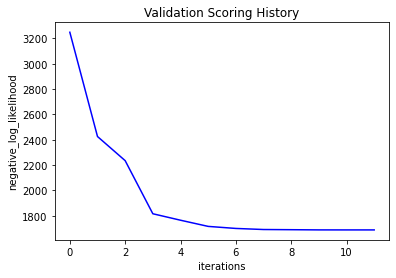

In [52]:
#plot out the scoring history
glm.plot(metric='negative_log_likelihood')

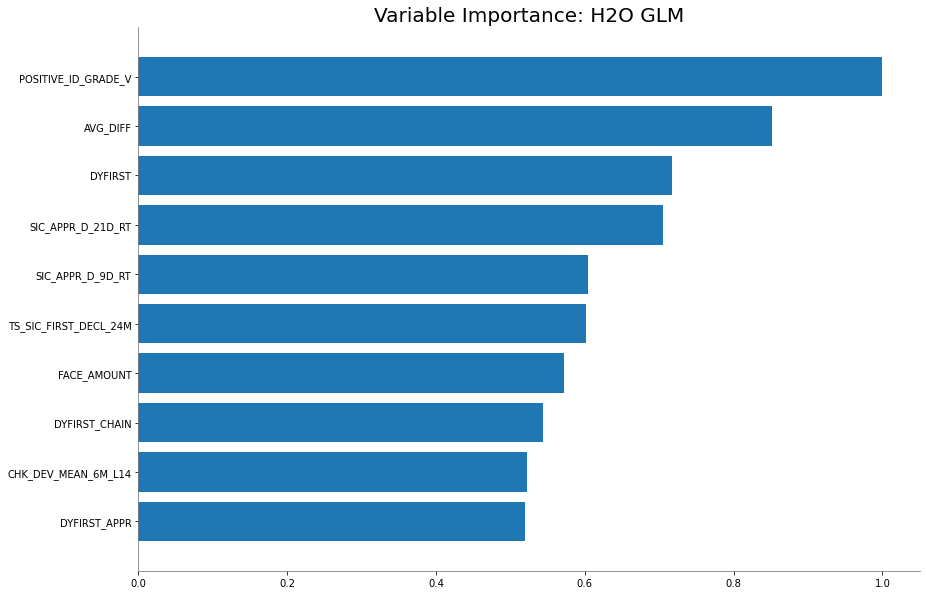

In [53]:
#plot out variable importance
glm.varimp_plot()

In [54]:
#save model performance
default_glm_perf=glm.model_performance(valid_h)

In [55]:
print("Default GLM AUC: %.4f \nDefault GLM AUCPR:%.4f" % (default_glm_perf.auc(), default_glm_perf.aucpr()))

Default GLM AUC: 0.9498 
Default GLM AUCPR:0.2070


In [56]:
#now utilizing the grid search for the optimal GLM model
glm_grid = h2o.grid.H2OGridSearch (
    
    H2OGeneralizedLinearEstimator(family = "binomial",
                                  lambda_search = True),
    
    hyper_params = {"alpha": [x*0.01 for x in range(0, 100)],
                    "missing_values_handling" : ["Skip", "MeanImputation"]},
    
    grid_id = "glm_random_grid",
    
    search_criteria = {
        "strategy":"RandomDiscrete",
        "max_models":300,
        "max_runtime_secs":300,
        "seed":42})

%time glm_grid.train(x = x, y = y, training_frame = train_h, validation_frame = valid_h)

glm Grid Build progress: |████████████████████████████████████████████████| 100%
Wall time: 5min 3s


In [57]:
sorted_glm_grid = glm_grid.get_grid(sort_by = 'auc', decreasing = True)
sorted_glm_grid.sorted_metric_table()

,,alpha,missing_values_handling,model_ids,auc
0,,[0.22],MeanImputation,glm_random_grid_model_35,0.9560026563766382
1,,[0.22],Skip,glm_random_grid_model_43,0.9560026563766382
2,,[0.25],Skip,glm_random_grid_model_51,0.956001851568051
3,,[0.23],Skip,glm_random_grid_model_32,0.9559313333924656
4,,[0.44],Skip,glm_random_grid_model_3,0.9558993041286087
5,,[0.21],Skip,glm_random_grid_model_44,0.9558717839107581
6,,[0.56],MeanImputation,glm_random_grid_model_39,0.9558231014628963
7,,[0.15],MeanImputation,glm_random_grid_model_48,0.9557960175360167
8,,[0.24],MeanImputation,glm_random_grid_model_54,0.9557843499294183
9,,[0.48],MeanImputation,glm_random_grid_model_10,0.9557777420273331


In [58]:
#select the best performing model based on AUC
tuned_glm = sorted_glm_grid.models[0]
tuned_glm.summary()


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.22, lambda = 6.952E-4 )","nlambda = 100, lambda.max = 0.06636, lambda.min = 6.952E-4, lambda...",185,85,99,py_5_sid_a2e8


In [59]:
#compare to our default
tuned_glm_perf = tuned_glm.model_performance(valid_h)
print("Default GLM AUC: %.4f  Default GLM AUCPR:%.4f" % (default_glm_perf.auc(), default_glm_perf.aucpr()))
print("Tuned GLM AUC: %.4f  Tuned GLM AUCPR:%.4f" % (tuned_glm_perf.auc(), tuned_glm_perf.aucpr()))

Default GLM AUC: 0.9498  Default GLM AUCPR:0.2070
Tuned GLM AUC: 0.9560  Tuned GLM AUCPR:0.2281


The default model outperforms regularized models
Some notes here on AUC PR (area under precision recall curve)
The big difference really between ROC and PR is how true negatives are treated
Key is with this imbalance we will see bigger differences in precision between models

Noting precision here is: True Positives / (True Positives + False Positves)

In [60]:
#let's look at the confusion matrix for each
print ("Default GLM: ", default_glm_perf.confusion_matrix())
print ("Tuned GLM: ",  tuned_glm_perf.confusion_matrix())

Default GLM:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14148264029159266: 


,,0,1,Error,Rate
0,0,192057.0,1452.0,0.0075,(1452.0/193509.0)
1,1,757.0,463.0,0.6205,(757.0/1220.0)
2,Total,192814.0,1915.0,0.0113,(2209.0/194729.0)



Tuned GLM:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1283357428870585: 


,,0,1,Error,Rate
0,0,192205.0,1304.0,0.0067,(1304.0/193509.0)
1,1,756.0,464.0,0.6197,(756.0/1220.0)
2,Total,192961.0,1768.0,0.0106,(2060.0/194729.0)


From the confusion matrices I am showing two different optimal thresholds based on F1
Error rate much higher for the regularized model in that a higher percentage of positives are being predicted as negatives

In [61]:
#start random forest
rf = H2ORandomForestEstimator (seed = 42, 
                               stopping_metric = 'aucpr',
                               model_id = 'default_rf')
%time rf.train(x = x, y = y, training_frame = train_h, validation_frame = valid_h)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Wall time: 6.98 s


In [62]:
rf

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  default_rf


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,328339.0,20.0,20.0,20.0,434.0,587.0,514.94




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.004526914206727557
RMSE: 0.06728234691750547
LogLoss: 0.02681784505313822
Mean Per-Class Error: 0.11710028266349415
AUC: 0.9276032845388241
AUCPR: 0.3478107842353015
Gini: 0.8552065690776482

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2600272900227674: 


,,0,1,Error,Rate
0,0,90891.0,196.0,0.0022,(196.0/91087.0)
1,1,358.0,170.0,0.678,(358.0/528.0)
2,Total,91249.0,366.0,0.006,(554.0/91615.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.260027,0.380313,126.0
1,max f2,0.130205,0.425220,195.0
2,max f0point5,0.342588,0.464385,98.0
3,max accuracy,0.479130,0.994903,61.0
4,max precision,0.947368,1.000000,0.0
5,max recall,0.000003,1.000000,399.0
6,max specificity,0.947368,1.000000,0.0
7,max absolute_mcc,0.285954,0.389098,116.0
8,max min_per_class_accuracy,0.001164,0.878788,384.0
9,max mean_per_class_accuracy,0.006917,0.882900,361.0



Gains/Lift Table: Avg response rate:  0.58 %, avg score:  0.59 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010009,0.133462,48.439906,48.439906,0.279171,2.886918e-01,0.279171,0.288692,0.484848,0.484848,4743.990615,4743.990615,0.477592
1,2,0.020008,0.071495,10.797222,29.628832,0.062227,9.670209e-02,0.170758,0.192749,0.107955,0.592803,979.722236,2862.883231,0.576116
2,3,0.030006,0.054006,7.766423,22.344014,0.044760,6.146865e-02,0.128774,0.149005,0.077652,0.670455,676.642310,2134.401353,0.644161
3,4,0.040004,0.041675,5.493324,18.132490,0.031659,4.816888e-02,0.104502,0.123803,0.054924,0.725379,449.332366,1713.249049,0.689347
4,5,0.050003,0.025915,3.409649,15.188565,0.019651,3.342093e-02,0.087535,0.105730,0.034091,0.759470,240.964917,1418.856500,0.713580
5,6,0.100005,0.002364,1.818083,8.503324,0.010478,9.742743e-03,0.049007,0.057737,0.090909,0.850379,81.808259,750.332380,0.754723
6,7,0.150008,0.000644,0.871165,5.959271,0.005021,1.186755e-03,0.034345,0.038887,0.043561,0.893939,-12.883542,495.927073,0.748244
7,8,0.200000,0.000308,0.303080,4.545455,0.001747,4.523724e-04,0.026197,0.029280,0.015152,0.909091,-69.692007,354.545455,0.713201
8,9,0.300049,0.000118,0.246091,3.111864,0.001418,1.867916e-04,0.017934,0.019579,0.024621,0.933712,-75.390876,211.186424,0.637336
9,10,0.400022,0.000064,0.075778,2.353091,0.000437,8.693337e-05,0.013561,0.014707,0.007576,0.941288,-92.422175,135.309127,0.544404




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.005485873843647251
RMSE: 0.07406668511312796
LogLoss: 0.026169167547987655
Mean Per-Class Error: 0.12630389580727763
AUC: 0.9340705507067956
AUCPR: 0.20194215293895884
Gini: 0.8681411014135911

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.177025768806537: 


,,0,1,Error,Rate
0,0,192558.0,951.0,0.0049,(951.0/193509.0)
1,1,853.0,367.0,0.6992,(853.0/1220.0)
2,Total,193411.0,1318.0,0.0093,(1804.0/194729.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.177026,0.289204,141.0
1,max f2,0.096984,0.359420,206.0
2,max f0point5,0.243588,0.299492,101.0
3,max accuracy,0.520780,0.993802,24.0
4,max precision,0.830000,1.000000,0.0
5,max recall,0.000009,1.000000,399.0
6,max specificity,0.830000,1.000000,0.0
7,max absolute_mcc,0.142511,0.288098,163.0
8,max min_per_class_accuracy,0.004966,0.872951,366.0
9,max mean_per_class_accuracy,0.002562,0.873696,375.0



Gains/Lift Table: Avg response rate:  0.63 %, avg score:  0.66 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.136457,36.625990,36.625990,0.229466,0.238651,0.229466,0.238651,0.366393,0.366393,3562.599009,3562.599009,0.358637
1,2,0.020285,0.080000,14.430630,25.376595,0.090410,0.101759,0.158987,0.169269,0.148361,0.514754,1343.063044,2437.659514,0.497587
2,3,0.030001,0.058052,9.617330,20.272773,0.060254,0.066075,0.127011,0.135849,0.093443,0.608197,861.733009,1927.277291,0.581841
3,4,0.040004,0.042057,6.554987,16.842446,0.041068,0.049085,0.105520,0.114152,0.065574,0.673770,555.498704,1584.244597,0.637762
4,5,0.050003,0.035734,4.590848,14.392630,0.028762,0.039743,0.090172,0.099274,0.045902,0.719672,359.084763,1339.262960,0.673891
5,6,0.100006,0.017388,2.196597,8.294613,0.013762,0.023311,0.051967,0.061292,0.109836,0.829508,119.659723,729.461341,0.734102
6,7,0.150003,0.002215,1.262353,5.950687,0.007909,0.007368,0.037282,0.043319,0.063115,0.892623,26.235343,495.068725,0.747302
7,8,0.200001,0.000749,0.590191,4.610632,0.003698,0.001287,0.028886,0.032812,0.029508,0.922131,-40.980879,361.063206,0.726683
8,9,0.300027,0.000212,0.278616,3.166379,0.001746,0.000413,0.019838,0.022010,0.027869,0.950000,-72.138445,216.637940,0.654071
9,10,0.400007,0.000098,0.106579,2.401596,0.000668,0.000144,0.015046,0.016545,0.010656,0.960656,-89.342128,140.159618,0.564183




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-02-02 15:54:46,0.068 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-02-02 15:54:47,0.710 sec,1.0,0.087354,0.225042,0.693436,0.079008,13.503697,0.009397,0.097053,0.260659,0.701149,0.061331,15.765590,0.012648
2,,2021-02-02 15:54:47,1.018 sec,2.0,0.083372,0.176357,0.738368,0.103350,21.477211,0.009308,0.084362,0.111122,0.780479,0.092531,22.953151,0.017368
3,,2021-02-02 15:54:48,1.221 sec,3.0,0.081825,0.160237,0.750146,0.119728,24.836211,0.009836,0.082068,0.095423,0.796444,0.100059,18.786677,0.020593
4,,2021-02-02 15:54:48,1.352 sec,4.0,0.080329,0.142116,0.764422,0.127329,29.139631,0.007955,0.080088,0.086835,0.811659,0.106347,17.846878,0.009321
5,,2021-02-02 15:54:48,1.472 sec,5.0,0.079644,0.128862,0.776854,0.143479,32.285927,0.007750,0.078433,0.075936,0.828440,0.127184,18.818680,0.009880
6,,2021-02-02 15:54:48,1.598 sec,6.0,0.078039,0.113090,0.768364,0.151932,34.816183,0.007547,0.077516,0.068175,0.838221,0.138562,27.466560,0.010805
7,,2021-02-02 15:54:48,1.738 sec,7.0,0.076944,0.100426,0.784244,0.160361,34.739806,0.011562,0.076965,0.063989,0.846715,0.144928,29.989066,0.011970
8,,2021-02-02 15:54:48,2.001 sec,8.0,0.075869,0.091150,0.795972,0.172137,35.194619,0.009182,0.076534,0.062296,0.852249,0.150868,31.054251,0.012402
9,,2021-02-02 15:54:49,2.137 sec,9.0,0.074528,0.079513,0.807226,0.191351,35.816106,0.008645,0.076205,0.052148,0.850649,0.153858,31.352737,0.010995



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,FACE_AMOUNT,979.060852,1.000000,0.083518
1,LOCAL_HOUR,477.537354,0.487750,0.040736
2,DYFIRST,278.234772,0.284185,0.023735
3,SIC_APPR_D_9D_RT,236.733978,0.241797,0.020195
4,MINS_BET_ILF_OLDVEL,177.701599,0.181502,0.015159
5,DYFIRST_APPR,173.556076,0.177268,0.014805
6,SIC_APPR_D_21D_RT,166.995056,0.170567,0.014245
7,DECL_D_3M_L1,163.138855,0.166628,0.013917
8,ALL_D_6D_RT,160.539169,0.163973,0.013695
9,R_T7D_T24M_APPR,160.068802,0.163492,0.013655



See the whole table with table.as_data_frame()


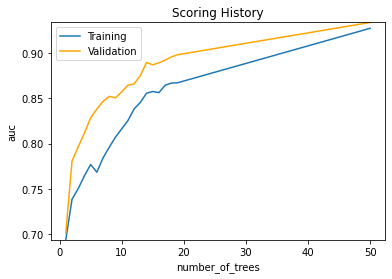

In [63]:
rf.plot(metric = 'auc')

In [64]:
#add in balance_classes = True
balanced_rf = H2ORandomForestEstimator (seed = 42, 
                               balance_classes = True,
                               stopping_metric = 'aucpr',
                               model_id = 'default_rf')
%time balanced_rf.train(x = x, y = y, training_frame = train_h, validation_frame = valid_h)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Wall time: 25.9 s


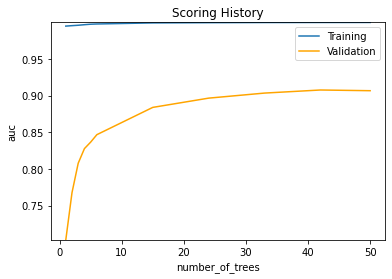

In [65]:
balanced_rf.plot(metric = 'auc')

In [66]:
balanced_rf

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  default_rf


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,428183.0,20.0,20.0,20.0,563.0,820.0,670.44




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.21331990853267924
RMSE: 0.4618656823500521
LogLoss: 0.6236351223577931
Mean Per-Class Error: 0.006812346374330369
AUC: 0.9995367911476237
AUCPR: 0.9994997067175888
Gini: 0.9990735822952475

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.024966147940277204: 


,,0,1,Error,Rate
0,0,90436.0,651.0,0.0071,(651.0/91087.0)
1,1,590.0,90492.0,0.0065,(590.0/91082.0)
2,Total,91026.0,91143.0,0.0068,(1241.0/182169.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.024966,0.993190,387.0
1,max f2,0.010342,0.996458,392.0
2,max f0point5,0.027688,0.993258,386.0
3,max accuracy,0.024966,0.993188,387.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.010342,1.000000,392.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.024966,0.986376,387.0
8,max min_per_class_accuracy,0.024966,0.992853,387.0
9,max mean_per_class_accuracy,0.024966,0.993188,387.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 21.39 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.991998,2.000055,2.000055,1.000000,0.999364,1.000000,0.999364,0.020004,0.020004,100.005490,100.005490,0.020004
1,2,0.020003,0.961736,2.000055,2.000055,1.000000,0.977199,1.000000,0.988282,0.020004,0.040008,100.005490,100.005490,0.040008
2,3,0.030011,0.938463,2.000055,2.000055,1.000000,0.949337,1.000000,0.975295,0.020015,0.060023,100.005490,100.005490,0.060023
3,4,0.040001,0.918066,2.000055,2.000055,1.000000,0.928194,1.000000,0.963531,0.019982,0.080005,100.005490,100.005490,0.080005
4,5,0.050003,0.895743,2.000055,2.000055,1.000000,0.907177,1.000000,0.952259,0.020004,0.100009,100.005490,100.005490,0.100009
5,6,0.100001,0.782284,2.000055,2.000055,1.000000,0.837814,1.000000,0.895040,0.099998,0.200007,100.005490,100.005490,0.200007
6,7,0.150004,0.653840,2.000055,2.000055,1.000000,0.721553,1.000000,0.837209,0.100009,0.300015,100.005490,100.005490,0.300015
7,8,0.200001,0.502743,2.000055,2.000055,1.000000,0.577357,1.000000,0.772249,0.099998,0.400013,100.005490,100.005490,0.400013
8,9,0.300002,0.237487,1.999945,2.000018,0.999945,0.364033,0.999982,0.636177,0.199996,0.600009,99.994511,100.001830,0.599998
9,10,0.400002,0.107478,1.994895,1.998737,0.997420,0.160073,0.999341,0.517151,0.199491,0.799499,99.489474,99.873741,0.798972




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.006138264879920472
RMSE: 0.07834707958769409
LogLoss: 0.04900163147635784
Mean Per-Class Error: 0.1227794145042942
AUC: 0.9066040813622511
AUCPR: 0.0780042389170198
Gini: 0.8132081627245022

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.01588674847749741: 


,,0,1,Error,Rate
0,0,190832.0,2677.0,0.0138,(2677.0/193509.0)
1,1,920.0,300.0,0.7541,(920.0/1220.0)
2,Total,191752.0,2977.0,0.0185,(3597.0/194729.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,1.588675e-02,0.142959,235.0
1,max f2,6.335711e-03,0.223122,306.0
2,max f0point5,3.215789e-02,0.132427,160.0
3,max accuracy,2.134657e-01,0.993740,0.0
4,max precision,2.134657e-01,1.000000,0.0
5,max recall,2.008681e-07,1.000000,399.0
6,max specificity,2.134657e-01,1.000000,0.0
7,max absolute_mcc,6.376661e-04,0.193369,380.0
8,max min_per_class_accuracy,1.883135e-04,0.875410,392.0
9,max mean_per_class_accuracy,2.388223e-04,0.877221,390.0



Gains/Lift Table: Avg response rate:  0.63 %, avg score:  0.09 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.022247,18.272026,18.272026,0.114476,0.041950,0.114476,0.041950,0.182787,0.182787,1727.202637,1727.202637,0.173873
1,2,0.020002,0.012133,11.477119,14.875445,0.071905,0.016400,0.093196,0.029178,0.114754,0.297541,1047.711907,1387.544498,0.279289
2,3,0.030011,0.007847,9.090378,12.946099,0.056952,0.009789,0.081109,0.022712,0.090984,0.388525,809.037800,1194.609940,0.360774
3,4,0.040004,0.004866,7.217896,11.515152,0.045221,0.006207,0.072144,0.018589,0.072131,0.460656,621.789632,1051.515162,0.423303
4,5,0.050003,0.003252,6.476374,10.507603,0.040575,0.003975,0.065831,0.015667,0.064754,0.525410,547.637433,950.760316,0.478404
5,6,0.100011,0.000365,5.982654,8.245012,0.037482,0.001313,0.051656,0.008490,0.299180,0.824590,498.265415,724.501248,0.729148
6,7,0.160161,0.000118,1.308199,5.639815,0.008196,0.000179,0.035334,0.005368,0.078689,0.903279,30.819924,463.981518,0.747803
7,8,0.200289,0.000038,0.449387,4.599920,0.002815,0.000088,0.028819,0.004310,0.018033,0.921311,-55.061344,359.991955,0.725569
8,9,0.348895,0.000003,0.022063,2.650052,0.000138,0.000005,0.016603,0.002476,0.003279,0.924590,-97.793712,165.005178,0.579325
9,10,1.000000,0.000000,0.115818,1.000000,0.000726,0.000000,0.006265,0.000864,0.075410,1.000000,-88.418174,0.000000,0.000000




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-02-02 15:55:37,0.051 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-02-02 15:55:39,1.772 sec,1.0,0.396460,0.510519,0.994571,0.991560,1.988938,0.015682,0.093479,0.223859,0.703456,0.063709,23.095020,0.013932
2,,2021-02-02 15:55:40,2.390 sec,2.0,0.395784,0.506732,0.995177,0.992400,1.989646,0.015653,0.080067,0.114255,0.767840,0.078159,19.900557,0.014610
3,,2021-02-02 15:55:40,2.978 sec,3.0,0.409187,0.527810,0.995727,0.993463,1.991777,0.014864,0.078130,0.091161,0.807873,0.081243,19.583024,0.012566
4,,2021-02-02 15:55:41,3.567 sec,4.0,0.419913,0.537711,0.996483,0.994634,1.993188,0.013124,0.077922,0.082177,0.827760,0.087447,16.713916,0.019252
5,,2021-02-02 15:55:42,4.144 sec,5.0,0.426740,0.544430,0.997147,0.995678,1.994646,0.010764,0.078079,0.078938,0.836556,0.083050,16.551342,0.017357
6,,2021-02-02 15:55:42,4.712 sec,6.0,0.431767,0.554491,0.997467,0.996259,1.995743,0.010736,0.078222,0.074999,0.846728,0.079038,18.353964,0.026195
7,,2021-02-02 15:55:46,8.967 sec,15.0,0.451496,0.597046,0.998916,0.998746,2.000055,0.008000,0.078311,0.060109,0.883876,0.073789,16.861780,0.019766
8,,2021-02-02 15:55:51,13.112 sec,24.0,0.456340,0.609153,0.999246,0.999154,2.000055,0.007438,0.078323,0.055289,0.896487,0.074320,17.288778,0.021897
9,,2021-02-02 15:55:55,17.280 sec,33.0,0.460309,0.618978,0.999442,0.999380,2.000055,0.007059,0.078353,0.052509,0.903374,0.075640,18.026214,0.020557



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,DYFIRST_CHAIN,147343.703125,1.000000,0.086480
1,DYFIRST_SIC,94760.031250,0.643122,0.055617
2,DYFIRST_Z3,89164.304688,0.605145,0.052333
3,APPR_C_24M_L14,88714.484375,0.602092,0.052069
4,DYFIRST,87886.929688,0.596476,0.051583
5,DYFIRST_APPR,70791.882812,0.480454,0.041550
6,MAX_APPR_ZIP_24M_L14,69600.757812,0.472370,0.040851
7,R_T12M_T24M_C,57798.601562,0.392271,0.033924
8,FACE_AMOUNT,56232.433594,0.381641,0.033004
9,CHALL_IND_MOD_Y,43378.906250,0.294406,0.025460



See the whole table with table.as_data_frame()


In [67]:
print("Default GLM AUC: %.4f  Default GLM AUCPR:%.4f" % (default_glm_perf.auc(), default_glm_perf.aucpr()))
print("Tuned GLM AUC: %.4f  Tuned GLM AUCPR:%.4f" % (tuned_glm_perf.auc(), tuned_glm_perf.aucpr()))
print("\n")
print("Default RF AUC: %.4f  Default RF AUCPR:%.4f" % (rf.auc(valid=True), rf.aucpr(valid=True)))
print("Balanced RF AUC: %.4f  Balanced RF AUCPR:%.4f" % (balanced_rf.auc(valid=True), balanced_rf.aucpr(valid=True)))

Default GLM AUC: 0.9498  Default GLM AUCPR:0.2070
Tuned GLM AUC: 0.9560  Tuned GLM AUCPR:0.2281


Default RF AUC: 0.9341  Default RF AUCPR:0.2019
Balanced RF AUC: 0.9066  Balanced RF AUCPR:0.0780


In [68]:
#Grid Search Parameters for Random Forest
hyper_parameters = {'max_depth':[1, 3, 5, 6, 7, 8, 9, 10, 12, 13, 15, 20, 25, 35]}

rf_for_grid = H2ORandomForestEstimator(seed = 42,
                              stopping_rounds = 5, 
                              stopping_tolerance = 1e-4, 
                              stopping_metric = "aucpr",
                              model_id = 'rf',
                              balance_classes = True)

grid_id = 'depth_grid'

search_criteria = {'strategy': "Cartesian"}

#Grid Search
rf_grid = H2OGridSearch(model = rf_for_grid, 
                        hyper_params = hyper_parameters, 
                        grid_id = grid_id, 
                        search_criteria = search_criteria)

%time rf_grid.train(x = x, y = y, training_frame = train_h, validation_frame = valid_h)

drf Grid Build progress: |████████████████████████████████████████████████| 100%
Wall time: 3min 2s


In [69]:
sorted_rf_depth = rf_grid.get_grid(sort_by = 'aucpr',decreasing = True)
sorted_rf_depth.sorted_metric_table()

,,max_depth,model_ids,aucpr
0,,5,depth_grid_model_3,0.1271139575708373
1,,6,depth_grid_model_4,0.12629542830327775
2,,8,depth_grid_model_6,0.12355527244811705
3,,7,depth_grid_model_5,0.12303473016275815
4,,10,depth_grid_model_8,0.12049998183033334
5,,3,depth_grid_model_2,0.11824873757400788
6,,9,depth_grid_model_7,0.11456802372562229
7,,12,depth_grid_model_9,0.09994963559562735
8,,13,depth_grid_model_10,0.09178915174635
9,,15,depth_grid_model_11,0.08613173022408034


In [70]:
hyper_parameters = {"max_depth":[5, 6, 7, 8, 9, 10],
                    'sample_rate': [x/100. for x in range(20,101)]}

rf_for_grid = H2ORandomForestEstimator(ntrees = 500,
                              seed = 42,
                              stopping_rounds = 5, 
                              stopping_tolerance = 1e-3, 
                              stopping_metric = "aucpr",
                              balance_classes = True,
                              model_id = 'rf_grid')

grid_id = 'rf_random_grid'

search_criteria = {"strategy":"RandomDiscrete",
                   "max_models":100,
                   "max_runtime_secs":900,
                   "seed":42}

rf_grid = H2OGridSearch(model = rf_for_grid, 
                        hyper_params = hyper_parameters, 
                        grid_id = grid_id, 
                        search_criteria = search_criteria)

%time rf_grid.train(x = x, y = y, training_frame = train_h, validation_frame = valid_h)

drf Grid Build progress: |████████████████████████████████████████████████| 100%
Wall time: 15min 2s


In [71]:
sorted_rf_grid = rf_grid.get_grid(sort_by = 'aucpr', decreasing = True)
sorted_rf_grid.sorted_metric_table()

,,max_depth,sample_rate,model_ids,aucpr
0,,5,0.96,rf_random_grid_model_25,0.13566172290765693
1,,5,0.29,rf_random_grid_model_7,0.13538272494523124
2,,5,0.84,rf_random_grid_model_23,0.13528577897272123
3,,5,0.38,rf_random_grid_model_4,0.13515805476198822
4,,5,0.45,rf_random_grid_model_18,0.1343399458171032
5,,5,0.77,rf_random_grid_model_9,0.13432825386290653
6,,5,0.42,rf_random_grid_model_11,0.13423948335935645
7,,7,0.68,rf_random_grid_model_22,0.13216368234953885
8,,8,0.26,rf_random_grid_model_12,0.13182565693399856
9,,6,0.71,rf_random_grid_model_5,0.12785833712382066


In [72]:
tuned_rf = sorted_rf_grid.models[0]
tuned_rf_per = tuned_rf.model_performance(valid_h)

In [73]:
print("Default GLM AUC: %.4f  Default GLM AUCPR:%.4f" % (default_glm_perf.auc(), default_glm_perf.aucpr()))
print("Tuned GLM AUC: %.4f  Tuned GLM AUCPR:%.4f" % (tuned_glm_perf.auc(), tuned_glm_perf.aucpr()))
print("\n")
print("Default RF AUC: %.4f  Default RF AUCPR:%.4f" % (rf.auc(valid=True), rf.aucpr(valid=True)))
print("Balanced RF AUC: %.4f  Balanced RF AUCPR:%.4f" % (balanced_rf.auc(valid=True), balanced_rf.aucpr(valid=True)))
print("\n")
print("Tuned RF AUC: %.4f  Tuned RF AUCPR:%.4f" % (tuned_rf_per.auc(), tuned_rf_per.aucpr()))

Default GLM AUC: 0.9498  Default GLM AUCPR:0.2070
Tuned GLM AUC: 0.9560  Tuned GLM AUCPR:0.2281


Default RF AUC: 0.9341  Default RF AUCPR:0.2019
Balanced RF AUC: 0.9066  Balanced RF AUCPR:0.0780


Tuned RF AUC: 0.9412  Tuned RF AUCPR:0.1357


In [74]:
print ("Default RF: ", rf.confusion_matrix(valid=True))
print ("Balanced RF: ", balanced_rf.confusion_matrix(valid=True))
print ("Tuned RF: ",  tuned_rf_per.confusion_matrix())

Default RF:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.177025768806537: 


,,0,1,Error,Rate
0,0,192558.0,951.0,0.0049,(951.0/193509.0)
1,1,853.0,367.0,0.6992,(853.0/1220.0)
2,Total,193411.0,1318.0,0.0093,(1804.0/194729.0)



Balanced RF:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.01588674847749741: 


,,0,1,Error,Rate
0,0,190832.0,2677.0,0.0138,(2677.0/193509.0)
1,1,920.0,300.0,0.7541,(920.0/1220.0)
2,Total,191752.0,2977.0,0.0185,(3597.0/194729.0)



Tuned RF:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.050600933976632345: 


,,0,1,Error,Rate
0,0,191939.0,1570.0,0.0081,(1570.0/193509.0)
1,1,852.0,368.0,0.6984,(852.0/1220.0)
2,Total,192791.0,1938.0,0.0124,(2422.0/194729.0)


In [75]:
gbm = H2OGradientBoostingEstimator(seed = 42, 
                                   model_id = 'default_gbm')

%time gbm.train(x = x, y = y, training_frame = train_h, validation_frame = valid_h)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Wall time: 5.38 s


In [76]:
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  default_gbm


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,11140.0,5.0,5.0,5.0,6.0,23.0,13.02




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.003567880647746158
RMSE: 0.05973173903165852
LogLoss: 0.0172544092797615
Mean Per-Class Error: 0.07071241788153915
AUC: 0.9739298838007352
AUCPR: 0.5506795421213132
Gini: 0.9478597676014704

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2577399601323582: 


,,0,1,Error,Rate
0,0,90943.0,144.0,0.0016,(144.0/91087.0)
1,1,274.0,254.0,0.5189,(274.0/528.0)
2,Total,91217.0,398.0,0.0046,(418.0/91615.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.257740,0.548596,152.0
1,max f2,0.060633,0.549400,255.0
2,max f0point5,0.471406,0.661560,87.0
3,max accuracy,0.471406,0.995907,87.0
4,max precision,0.972285,0.956897,11.0
5,max recall,0.000134,1.000000,399.0
6,max specificity,0.999919,0.999945,0.0
7,max absolute_mcc,0.318513,0.555196,128.0
8,max min_per_class_accuracy,0.004113,0.927915,360.0
9,max mean_per_class_accuracy,0.003787,0.929288,362.0



Gains/Lift Table: Avg response rate:  0.58 %, avg score:  0.58 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010009,7.787965e-02,61.685193,61.685193,0.355507,0.352827,0.355507,0.352827,0.617424,0.617424,6068.519299,6068.519299,0.610936
1,2,0.020040,3.995424e-02,13.782881,37.707946,0.079434,0.052816,0.217320,0.202658,0.138258,0.755682,1278.288118,3670.794650,0.739906
2,3,0.030585,2.557455e-02,6.107092,26.813433,0.035197,0.030094,0.154532,0.143166,0.064394,0.820076,510.709188,2581.343345,0.794068
3,4,0.041478,1.807594e-02,2.955637,20.547623,0.017034,0.020519,0.118421,0.110955,0.032197,0.852273,195.563665,1954.762261,0.815495
4,5,0.050985,1.207588e-02,3.785019,17.421905,0.021814,0.014480,0.100407,0.092965,0.035985,0.888258,278.501940,1642.190490,0.842126
5,6,0.100027,2.621817e-03,1.081320,9.410311,0.006232,0.005619,0.054234,0.050141,0.053030,0.941288,8.132010,841.031089,0.846137
6,7,0.150019,1.651404e-03,0.416735,6.413325,0.002402,0.002015,0.036962,0.034103,0.020833,0.962121,-58.326510,541.332471,0.816810
7,8,0.200022,1.350581e-03,0.227260,4.866893,0.001310,0.001466,0.028049,0.025944,0.011364,0.973485,-77.273968,386.689301,0.777947
8,9,0.300147,8.522251e-04,0.113494,3.281217,0.000654,0.001125,0.018910,0.017665,0.011364,0.984848,-88.650610,228.121660,0.688670
9,10,0.453386,7.541049e-04,0.024719,2.180560,0.000142,0.000784,0.012567,0.011959,0.003788,0.988636,-97.528125,118.055999,0.538353




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.0061565209443792636
RMSE: 0.07846350071453136
LogLoss: 0.031376559240591496
Mean Per-Class Error: 0.13014568560330442
AUC: 0.9273880767523076
AUCPR: 0.16191968539317947
Gini: 0.8547761535046152

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10675828223530025: 


,,0,1,Error,Rate
0,0,192043.0,1466.0,0.0076,(1466.0/193509.0)
1,1,823.0,397.0,0.6746,(823.0/1220.0)
2,Total,192866.0,1863.0,0.0118,(2289.0/194729.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.106758,0.257541,234.0
1,max f2,0.055976,0.320839,273.0
2,max f0point5,0.292776,0.263095,146.0
3,max accuracy,0.997650,0.993730,1.0
4,max precision,0.997650,0.494949,1.0
5,max recall,0.000082,1.000000,399.0
6,max specificity,0.999841,0.999757,0.0
7,max absolute_mcc,0.065101,0.259717,263.0
8,max min_per_class_accuracy,0.002453,0.867213,376.0
9,max mean_per_class_accuracy,0.002034,0.869854,380.0



Gains/Lift Table: Avg response rate:  0.63 %, avg score:  0.63 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010271,9.790079e-02,32.880470,32.880470,0.206000,0.326633,0.206000,0.326633,0.337705,0.337705,3188.047049,3188.047049,0.329499
1,2,0.020012,4.862202e-02,11.947907,22.690818,0.074855,0.064733,0.142161,0.199144,0.116393,0.454098,1094.790653,2169.081849,0.436823
2,3,0.030314,3.379456e-02,9.070782,18.062360,0.056830,0.040755,0.113163,0.145319,0.093443,0.547541,807.078192,1706.235951,0.520488
3,4,0.040051,2.491602e-02,5.135258,14.919677,0.032173,0.027467,0.093474,0.116668,0.050000,0.597541,413.525844,1391.967665,0.561005
4,5,0.050301,1.916666e-02,4.158279,12.726747,0.026052,0.021100,0.079735,0.097194,0.042623,0.640164,315.827885,1172.674658,0.593582
5,6,0.100026,3.919558e-03,3.247335,8.014294,0.020345,0.010373,0.050210,0.054033,0.161475,0.801639,224.733503,701.429448,0.706037
6,7,0.150096,2.035303e-03,1.637066,5.886952,0.010256,0.002732,0.036882,0.036920,0.081967,0.883607,63.706599,488.695160,0.738135
7,8,0.201429,1.448055e-03,0.558872,4.529123,0.003501,0.001686,0.028375,0.027941,0.028689,0.912295,-44.112768,352.912271,0.715348
8,9,0.300145,1.135552e-03,0.290615,3.135093,0.001821,0.001264,0.019642,0.019167,0.028689,0.940984,-70.938523,213.509328,0.644879
9,10,0.402246,7.718428e-04,0.280982,2.410643,0.001760,0.000897,0.015103,0.014530,0.028689,0.969672,-71.901782,141.064337,0.571003




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-02-02 19:37:06,0.054 sec,0.0,0.075697,0.035463,0.500000,0.005763,1.000000,0.994237,0.078906,0.038048,0.500000,0.006265,1.000000,0.993735
1,,2021-02-02 19:37:06,0.457 sec,1.0,0.068530,0.026992,0.878326,0.364131,24.129075,0.006986,0.079943,0.035606,0.844013,0.132361,17.251148,0.008807
2,,2021-02-02 19:37:07,0.668 sec,2.0,0.068159,0.029063,0.863586,0.374458,46.098102,0.006003,0.079216,0.034391,0.845958,0.147963,28.410500,0.009177
3,,2021-02-02 19:37:07,0.993 sec,3.0,0.067272,0.025741,0.886555,0.391803,49.056104,0.005294,0.078916,0.033955,0.848169,0.154089,28.378948,0.009490
4,,2021-02-02 19:37:07,1.134 sec,4.0,0.066925,0.025173,0.910604,0.398286,49.063604,0.005272,0.078745,0.033666,0.863078,0.155186,27.991478,0.009357
5,,2021-02-02 19:37:07,1.227 sec,5.0,0.066571,0.024660,0.912562,0.403722,49.971818,0.005741,0.078613,0.033366,0.863942,0.153533,29.722829,0.009834
6,,2021-02-02 19:37:07,1.313 sec,6.0,0.066183,0.024044,0.914015,0.411244,52.996984,0.005490,0.078504,0.033112,0.863144,0.151734,29.815295,0.011462
7,,2021-02-02 19:37:07,1.399 sec,7.0,0.065646,0.023338,0.921317,0.422706,53.403108,0.006036,0.078377,0.032705,0.865345,0.154205,30.146583,0.010019
8,,2021-02-02 19:37:07,1.493 sec,8.0,0.064941,0.022529,0.939907,0.444056,54.803438,0.005152,0.078406,0.032362,0.887040,0.156211,30.623131,0.010096
9,,2021-02-02 19:37:08,1.580 sec,9.0,0.064397,0.021856,0.945410,0.447126,55.641382,0.005359,0.078186,0.032015,0.890753,0.157896,30.676309,0.014430



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,FACE_AMOUNT,51.701401,1.000000,0.113881
1,ALL_D_6D_RT,47.311535,0.915092,0.104212
2,ALL_C_21D_RT,42.757961,0.827017,0.094182
3,DYFIRST_APPR,42.510910,0.822239,0.093638
4,APPR_C_14D_L1,30.949869,0.598627,0.068173
5,DYFIRST,14.432796,0.279157,0.031791
6,T24M_A9DAY_D,9.454318,0.182864,0.020825
7,POSITIVE_ID_GRADE_B,9.086606,0.175752,0.020015
8,DECL_D_3M_L1,8.988404,0.173852,0.019799
9,TS_SIC_MAX_ATTEMPT_24M,8.545650,0.165289,0.018823



See the whole table with table.as_data_frame()


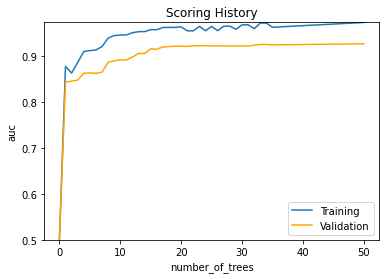

In [77]:
gbm.plot(metric = 'auc')

In [78]:
balanced_gbm = H2OGradientBoostingEstimator(seed = 42, 
                                   balance_classes = True,
                                   model_id = 'balanced_gbm')

%time balanced_gbm.train(x = x, y = y, training_frame = train_h, validation_frame = valid_h)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Wall time: 9.9 s


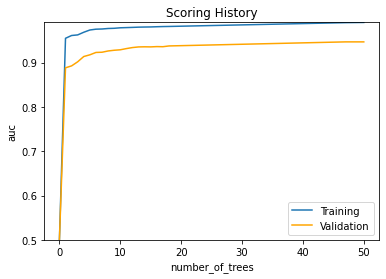

In [79]:
balanced_gbm.plot(metric = 'auc')

In [80]:
print("Default GBM AUC: %.4f  Default GBM AUCPR:%.4f" % (gbm.auc(valid=True), gbm.aucpr(valid=True)))
print("Balanced GBM AUC: %.4f  Balanced GBM AUCPR:%.4f" % (balanced_gbm.auc(valid=True), balanced_gbm.aucpr(valid=True)))

Default GBM AUC: 0.9274  Default GBM AUCPR:0.1619
Balanced GBM AUC: 0.9467  Balanced GBM AUCPR:0.1765


In [81]:
print ("Default GBM: ", gbm.confusion_matrix(valid=True))
print ("Balanced GBM: ", balanced_gbm.confusion_matrix(valid=True))

Default GBM:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10675828223530025: 


,,0,1,Error,Rate
0,0,192043.0,1466.0,0.0076,(1466.0/193509.0)
1,1,823.0,397.0,0.6746,(823.0/1220.0)
2,Total,192866.0,1863.0,0.0118,(2289.0/194729.0)



Balanced GBM:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06868036180657362: 


,,0,1,Error,Rate
0,0,191944.0,1565.0,0.0081,(1565.0/193509.0)
1,1,796.0,424.0,0.6525,(796.0/1220.0)
2,Total,192740.0,1989.0,0.0121,(2361.0/194729.0)


In [82]:
hyper_params = {'max_depth' : [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15]}

gbm_for_grid = H2OGradientBoostingEstimator(model_id = 'grid_gbm', 
                                   ntrees = 50,
                                   seed = 42)

gbm_grid = H2OGridSearch(gbm_for_grid, hyper_params,
                         grid_id = 'depth_gbm_grid',
                         search_criteria = {"strategy":"Cartesian"})

%time gbm_grid.train(x = x, y = y, training_frame = train_h, validation_frame = valid_h)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Wall time: 1min 3s


In [83]:
sorted_gbm_depth = gbm_grid.get_grid(sort_by = 'aucpr', decreasing = True)
sorted_gbm_depth.sorted_metric_table()

,,max_depth,model_ids,aucpr
0,,3,depth_gbm_grid_model_1,0.17135114028732884
1,,5,depth_gbm_grid_model_3,0.16191968539317947
2,,4,depth_gbm_grid_model_2,0.16080113497024273
3,,6,depth_gbm_grid_model_4,0.15116576857394823
4,,8,depth_gbm_grid_model_6,0.14430051082293605
5,,7,depth_gbm_grid_model_5,0.1273402712585185
6,,9,depth_gbm_grid_model_7,0.12375762370654218
7,,12,depth_gbm_grid_model_9,0.1132260228140398
8,,13,depth_gbm_grid_model_10,0.11115070225348928
9,,10,depth_gbm_grid_model_8,0.10150237752292544


In [84]:
gbm_for_grid_2 = H2OGradientBoostingEstimator(ntrees = 500,
                                   learn_rate = 0.05,
                                   seed = 42,
                                   model_id = 'grid_gbm')

hyper_params_tune = {'max_depth' : [3, 4, 5, 6, 7, 8],
                     'sample_rate': [x/100. for x in range(20,101)],
                     'col_sample_rate' : [x/100. for x in range(20,101)],
                     'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                     'col_sample_rate_change_per_level': [x/100. for x in range(90,111)]}

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 900,  
                        'max_models': 100,  ## build no more than 100 models
                        'seed' : 42}

random_grid = H2OGridSearch(model = gbm_for_grid_2, hyper_params = hyper_params_tune,
                            grid_id = 'random_grid',
                            search_criteria = search_criteria_tune)

%time random_grid.train(x = x, y = y, training_frame = train_h, validation_frame = valid_h)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Wall time: 15min 3s


In [85]:
sorted_random_search = random_grid.get_grid(sort_by = 'aucpr',decreasing = True)
sorted_random_search.sorted_metric_table()

,,col_sample_rate,col_sample_rate_change_per_level,col_sample_rate_per_tree,max_depth,sample_rate,model_ids,aucpr
0,,0.21,0.97,0.77,3,0.87,random_grid_model_42,0.22833324907750144
1,,0.33,1.01,0.38,3,0.99,random_grid_model_30,0.22787949480353895
2,,0.93,1.07,0.3,3,0.61,random_grid_model_47,0.22426975887543185
3,,0.5,0.99,0.45,3,0.94,random_grid_model_39,0.21586940689396064
4,,1.0,0.94,0.87,3,0.51,random_grid_model_4,0.210310841210415
5,,0.88,0.95,0.2,3,0.38,random_grid_model_6,0.2097535970278357
6,,0.22,1.0,0.47,4,0.69,random_grid_model_45,0.20820173775303658
7,,0.57,0.97,0.51,4,0.21,random_grid_model_38,0.20695788350493532
8,,0.22,0.92,0.87,4,0.9,random_grid_model_12,0.20180044596155564
9,,0.64,0.93,0.25,4,0.41,random_grid_model_52,0.20163728483280202


In [86]:
tuned_gbm = sorted_random_search.models[0]

In [87]:
print("Default GBM AUC: %.4f  Default GBM AUCPR:%.4f" % (gbm.auc(valid=True), gbm.aucpr(valid=True)))
print("Balanced GBM AUC: %.4f  Balanced GBM AUCPR:%.4f" % (balanced_gbm.auc(valid=True), balanced_gbm.aucpr(valid=True)))
print("Tuned GBM AUC: %.4f  Tuned GBM AUCPR:%.4f" % (tuned_gbm.auc(valid=True), tuned_gbm.aucpr(valid=True)))

Default GBM AUC: 0.9274  Default GBM AUCPR:0.1619
Balanced GBM AUC: 0.9467  Balanced GBM AUCPR:0.1765
Tuned GBM AUC: 0.9565  Tuned GBM AUCPR:0.2283


In [89]:
glm_test_per = tuned_glm.model_performance(test_h)
rf_test_per = tuned_rf.model_performance(test_h)
gbm_test_per = tuned_gbm.model_performance(test_h)

In [91]:
print("Tuned GLM AUC: %.4f  Tuned GLM AUCPR:%.4f" % (glm_test_per.auc(), glm_test_per.aucpr()))
print("Tuned RF AUC: %.4f  Tuned RF AUCPR:%.4f" % (rf_test_per.auc(), rf_test_per.aucpr()))
print("Tuned GBM AUC: %.4f  Tuned GBM AUCPR:%.4f" % (gbm_test_per.auc(), gbm_test_per.aucpr()))

Tuned GLM AUC: 0.9304  Tuned GLM AUCPR:0.1279
Tuned RF AUC: 0.9212  Tuned RF AUCPR:0.0758
Tuned GBM AUC: 0.9322  Tuned GBM AUCPR:0.1381


In [92]:
print ("Tuned GLM: ", glm_test_per.confusion_matrix())
print ("Tuned RF: ", rf_test_per.confusion_matrix())
print ("Tuned GBM: ", gbm_test_per.confusion_matrix())

Tuned GLM:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08344525470084452: 


,,0,1,Error,Rate
0,0,139873.0,1054.0,0.0075,(1054.0/140927.0)
1,1,460.0,231.0,0.6657,(460.0/691.0)
2,Total,140333.0,1285.0,0.0107,(1514.0/141618.0)



Tuned RF:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04513775648709331: 


,,0,1,Error,Rate
0,0,139664.0,1263.0,0.009,(1263.0/140927.0)
1,1,504.0,187.0,0.7294,(504.0/691.0)
2,Total,140168.0,1450.0,0.0125,(1767.0/141618.0)



Tuned GBM:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09377900540472156: 


,,0,1,Error,Rate
0,0,140298.0,629.0,0.0045,(629.0/140927.0)
1,1,520.0,171.0,0.7525,(520.0/691.0)
2,Total,140818.0,800.0,0.0081,(1149.0/141618.0)


In [94]:
glm_test_per


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.004552977656376328
RMSE: 0.0674757560637621
LogLoss: 0.021521758522846057
Null degrees of freedom: 141617
Residual degrees of freedom: 141532
Null deviance: 8755.03660598314
Residual deviance: 6095.736796976826
AIC: 6267.736796976826
AUC: 0.9304492887630537
AUCPR: 0.12786424660156762
Gini: 0.8608985775261073

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08344525470084452: 


,,0,1,Error,Rate
0,0,139873.0,1054.0,0.0075,(1054.0/140927.0)
1,1,460.0,231.0,0.6657,(460.0/691.0)
2,Total,140333.0,1285.0,0.0107,(1514.0/141618.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.083445,0.233806,190.0
1,max f2,0.065391,0.299894,213.0
2,max f0point5,0.231630,0.227412,96.0
3,max accuracy,0.952525,0.995114,0.0
4,max precision,0.764136,0.411765,13.0
5,max recall,0.000072,1.000000,399.0
6,max specificity,0.952525,0.999993,0.0
7,max absolute_mcc,0.083445,0.240166,190.0
8,max min_per_class_accuracy,0.003813,0.873438,356.0
9,max mean_per_class_accuracy,0.004240,0.875009,354.0



Gains/Lift Table: Avg response rate:  0.49 %, avg score:  0.50 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010006,0.078179,34.278271,34.278271,0.167255,0.169342,0.167255,0.169342,0.342981,0.342981,3327.827078,3327.827078,0.334608
1,2,0.020005,0.052186,10.855215,22.570877,0.052966,0.063248,0.110131,0.116314,0.108538,0.451520,985.521475,2157.087673,0.433631
2,3,0.030003,0.040724,9.263117,18.136001,0.045198,0.045836,0.088491,0.092827,0.092619,0.544139,826.311658,1713.600067,0.516657
3,4,0.040002,0.033154,4.776294,14.796664,0.023305,0.036581,0.072198,0.078768,0.047757,0.591896,377.629449,1379.666370,0.554600
4,5,0.050008,0.028078,4.917558,12.820006,0.023994,0.030496,0.062553,0.069109,0.049204,0.641100,391.755783,1182.000555,0.593990
5,6,0.100001,0.006539,3.618405,8.219855,0.017655,0.016156,0.040107,0.042636,0.180897,0.821997,261.840492,721.985497,0.725536
6,7,0.150002,0.002882,1.389271,5.942994,0.006779,0.004228,0.028998,0.029834,0.069465,0.891462,38.927126,494.299374,0.745095
7,8,0.200003,0.001788,0.549920,4.594725,0.002683,0.002258,0.022419,0.022940,0.027496,0.918958,-45.008013,359.472527,0.722480
8,9,0.300004,0.000970,0.289432,3.159627,0.001412,0.001299,0.015417,0.015726,0.028944,0.947902,-71.056849,215.962735,0.651074
9,10,0.399999,0.000645,0.159199,2.409560,0.000777,0.000788,0.011757,0.011992,0.015919,0.963821,-84.080143,140.955988,0.566587


In [97]:
deep_dive.head()

,NET_LOSS_BINARY,FACE_AMOUNT,LOCAL_HOUR,NO_ID,NID_NO,AGE,APPR_C_3M_RT,ALL_C_21D_RT,ALL_D_21D_RT,MIN_DECL_21D_RT,...,LAST_CHK_UNAPP_N,LAST_CHK_UNAPP_Y,wZIP3_-555,wZIP3_1,wZIP3_666,CHALL_IND_MOD_N,CHALL_IND_MOD_Y,wCHECK_NUMBER_1,wCHECK_NUMBER_2,wCHECK_NUMBER_3
0,0,27.99,17.0,-999.0,-999.0,56.0,3.0,2.0,250.21,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0,106.92,15.0,-999.0,-999.0,57.0,19.0,4.0,471.81,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0,45.37,18.0,-999.0,-999.0,74.0,15.0,5.0,141.87,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0,106.51,11.0,-999.0,-999.0,91.0,14.0,0.0,-999.00,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0,32.98,14.0,-999.0,-999.0,37.0,1.0,0.0,-999.00,-999.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [100]:
#score my deep dive data set for comparison with what I have from my final logistic regression model
#start with GLM model
h2o_glm_predict = tuned_glm.predict(deep_dive_h)
glm_pred_df = h2o.as_list(h2o_glm_predict)
glm_pred_df.drop(columns = ['predict','p0'], inplace=True)
glm_pred_df.rename(columns = {'p1':'TUNED_GLM_PRED'}, inplace=True)

glm_pred_df.head()

glm prediction progress: |████████████████████████████████████████████████| 100%


,TUNED_GLM_PRED
0,0.000119
1,0.000575
2,0.000105
3,0.000115
4,0.001306


In [101]:
#random forest
h2o_rf_predict = tuned_rf.predict(deep_dive_h)
rf_pred_df = h2o.as_list(h2o_rf_predict)
rf_pred_df.drop(columns = ['predict','p0'], inplace=True)
rf_pred_df.rename(columns = {'p1':'TUNED_RF_PRED'}, inplace=True)

rf_pred_df.head()

drf prediction progress: |████████████████████████████████████████████████| 100%


,TUNED_RF_PRED
0,0.000326
1,0.000484
2,0.000322
3,0.000379
4,0.003204


In [102]:
#gbm prediction
h2o_gbm_predict = tuned_gbm.predict(deep_dive_h)
gbm_pred_df = h2o.as_list(h2o_gbm_predict)
gbm_pred_df.drop(columns = ['predict','p0'], inplace=True)
gbm_pred_df.rename(columns = {'p1':'TUNED_GBM_PRED'}, inplace=True)

gbm_pred_df.head()

gbm prediction progress: |████████████████████████████████████████████████| 100%


,TUNED_GBM_PRED
0,0.000269
1,0.000479
2,0.000243
3,0.000341
4,0.001628


In [103]:
#merge predictions together on the deep dive data set keeping TXN_UID
score_log_df = pd.merge(analysis_df['TXN_UID'], glm_pred_df, how='inner', left_index=True, right_index=True)
score_log_df = pd.merge(score_log_df, rf_pred_df, how='inner', left_index=True, right_index=True)
score_log_df = pd.merge(score_log_df, gbm_pred_df, how='inner', left_index=True, right_index=True)

score_log_df.head()

,TXN_UID,TUNED_GLM_PRED,TUNED_RF_PRED,TUNED_GBM_PRED
0,2304020008662,0.000119,0.000326,0.000269
1,2304030005910,0.000575,0.000484,0.000479
2,2304030009042,0.000105,0.000322,0.000243
3,2304060001575,0.000115,0.000379,0.000341
4,2304080004328,0.001306,0.003204,0.001628


In [104]:
glm_pred_df.shape[0]
rf_pred_df.shape[0]
gbm_pred_df.shape[0]
score_log_df.shape[0]

443578

443578

443578

443578

In [105]:
#export data frame for use in evaluating against other models
score_log_df.to_csv("./net loss scores from h2o.csv", index = False)

In [106]:
h2o.cluster().shutdown()

H2O session _sid_a2e8 closed.
